## Import data from AWS S3

In [1]:
# from sagemaker import get_execution_role
# role = get_execution_role()

In [1]:
import boto3
import pandas as pd

bucket = 'dsci-632'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket="dsci-632", Key="CA_3_sales_data.csv")
df = pd.read_csv(obj['Body'], index_col=0, parse_dates=True) # 'Body' is a keyword
print(df.head())

            wm_yr_wk  wday  month  year event_name_1 event_type_1  \
2011-01-29     11101     1      1  2011         None         None   
2011-01-30     11101     2      1  2011         None         None   
2011-01-31     11101     3      1  2011         None         None   
2011-02-01     11101     4      2  2011         None         None   
2011-02-02     11101     5      2  2011         None         None   

           event_name_2 event_type_2      cpi  unemployment_rate  gas_price  \
2011-01-29         None         None  221.187                9.1      3.163   
2011-01-30         None         None  221.187                9.1      3.163   
2011-01-31         None         None  221.187                9.1      3.155   
2011-02-01         None         None  221.898                9.0      3.155   
2011-02-02         None         None  221.898                9.0      3.155   

            snap_ca  ca_walmart  ca_hobbies  ca_household  ca_foods  \
2011-01-29        0       39.50       2

## Data Processing

In [2]:
def get_day_value(df):
    """ Preprocessing function
    Creates day column.
    """
    df = df.assign(**{'day': df.index.day})
    
    return df
df_processed = df.pipe(get_day_value)

event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
df_processed = df_processed.join([pd.get_dummies(df[col], prefix=col) for col in event_cols]).drop(event_cols, axis=1).rename(str.lower, axis=1)
pd.set_option('display.max_columns', None)
print(df_processed.head(1))

            wm_yr_wk  wday  month  year      cpi  unemployment_rate  \
2011-01-29     11101     1      1  2011  221.187                9.1   

            gas_price  snap_ca  ca_walmart  ca_hobbies  ca_household  \
2011-01-29      3.163        0        39.5       20.14          36.5   

            ca_foods  store_sales  median_price  min_price  max_price  day  \
2011-01-29      63.0       4739.0           3.0        0.2       22.0   29   

            event_name_1_chanukah end  event_name_1_christmas  \
2011-01-29                          0                       0   

            event_name_1_cinco de mayo  event_name_1_columbusday  \
2011-01-29                           0                         0   

            event_name_1_easter  event_name_1_eid al-fitr  \
2011-01-29                    0                         0   

            event_name_1_eidaladha  event_name_1_father's day  \
2011-01-29                       0                          0   

            event_name_1_hallowee

## Data Analysis

In [3]:
timeseries_cols = ['cpi', 'unemployment_rate', 'gas_price', 'ca_walmart', 'ca_hobbies', 'ca_household', 'ca_foods']
time_cols = ['wm_yr_wk', 'wday', 'day', 'month', 'year']
target_col = ['store_sales', 'median_price', 'min_price', 'max_price']
cat_cols = [col for col in df_processed.columns if col not in timeseries_cols + time_cols + target_col]

print(cat_cols)

['snap_ca', 'event_name_1_chanukah end', 'event_name_1_christmas', 'event_name_1_cinco de mayo', 'event_name_1_columbusday', 'event_name_1_easter', 'event_name_1_eid al-fitr', 'event_name_1_eidaladha', "event_name_1_father's day", 'event_name_1_halloween', 'event_name_1_independenceday', 'event_name_1_laborday', 'event_name_1_lentstart', 'event_name_1_lentweek2', 'event_name_1_martinlutherkingday', 'event_name_1_memorialday', "event_name_1_mother's day", 'event_name_1_nbafinalsend', 'event_name_1_nbafinalsstart', 'event_name_1_newyear', 'event_name_1_none', 'event_name_1_orthodoxchristmas', 'event_name_1_orthodoxeaster', 'event_name_1_pesach end', 'event_name_1_presidentsday', 'event_name_1_purim end', 'event_name_1_ramadan starts', 'event_name_1_stpatricksday', 'event_name_1_superbowl', 'event_name_1_thanksgiving', 'event_name_1_valentinesday', 'event_name_1_veteransday', 'event_type_1_cultural', 'event_type_1_national', 'event_type_1_none', 'event_type_1_religious', 'event_type_1_spo

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.

#     data      : pandas dataframe containing the time series variables
#     variables : list containing names of the time series variables.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

df_used = df_processed[timeseries_cols+target_col+cat_cols+time_cols]
df_used = df_used.rolling(30).mean().dropna()
# grangers_causation_matrix(df_used, variables = df_used.columns)  

In [6]:
nobs = 30
df_original = df_used
df_test = df_used[-nobs:]
df_used = df_used[0:-nobs]
df_original.head()

,cpi,unemployment_rate,gas_price,ca_walmart,ca_hobbies,ca_household,ca_foods,store_sales,median_price,min_price,max_price,snap_ca,event_name_1_chanukah end,event_name_1_christmas,event_name_1_cinco de mayo,event_name_1_columbusday,event_name_1_easter,event_name_1_eid al-fitr,event_name_1_eidaladha,event_name_1_father's day,event_name_1_halloween,event_name_1_independenceday,event_name_1_laborday,event_name_1_lentstart,event_name_1_lentweek2,event_name_1_martinlutherkingday,event_name_1_memorialday,event_name_1_mother's day,event_name_1_nbafinalsend,event_name_1_nbafinalsstart,event_name_1_newyear,event_name_1_none,event_name_1_orthodoxchristmas,event_name_1_orthodoxeaster,event_name_1_pesach end,event_name_1_presidentsday,event_name_1_purim end,event_name_1_ramadan starts,event_name_1_stpatricksday,event_name_1_superbowl,event_name_1_thanksgiving,event_name_1_valentinesday,event_name_1_veteransday,event_type_1_cultural,event_type_1_national,event_type_1_none,event_type_1_religious,event_type_1_sporting,event_name_2_cinco de mayo,event_name_2_easter,event_name_2_father's day,event_name_2_none,event_name_2_orthodoxeaster,event_type_2_cultural,event_type_2_none,event_type_2_religious,wm_yr_wk,wday,day,month,year
2011-02-27,221.826900,9.010000,3.191933,43.011000,21.595333,41.843333,58.445333,4317.966667,3.138,0.2,22.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.033333,0.033333,0.9,0.0,0.033333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11102.666667,3.833333,15.600000,1.900000,2011.0
2011-02-28,221.850600,9.006667,3.201000,43.072333,21.788000,42.460000,58.281333,4280.133333,3.144,0.2,22.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.033333,0.033333,0.9,0.0,0.033333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11102.800000,3.900000,15.566667,1.933333,2011.0
2011-03-01,221.912567,9.003333,3.210067,42.928333,21.707333,42.743333,58.272000,4247.433333,3.150,0.2,22.0,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.033333,0.033333,0.9,0.0,0.033333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11102.933333,3.966667,14.600000,2.000000,2011.0
2011-03-02,221.974533,9.000000,3.219400,42.877000,21.481333,42.810000,58.519000,4248.633333,3.156,0.2,22.0,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.033333,0.033333,0.9,0.0,0.033333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11103.066667,4.033333,13.633333,2.066667,2011.0
2011-03-03,222.012800,9.000000,3.228733,42.644333,21.198000,42.860000,58.476000,4232.800000,3.162,0.2,22.0,0.400000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.033333,0.0,0.033333,0.0,0.033333,0.033333,0.9,0.0,0.033333,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,11103.200000,4.100000,13.700000,2.100000,2011.0


In [7]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")

for name, column in df_used.iteritems():
    adfuller_test(column, name=column.name)

 cpi : P-Value = 0.576 => Non-stationary.
 unemployment_rate : P-Value = 0.847 => Non-stationary.
 gas_price : P-Value = 0.568 => Non-stationary.
 ca_walmart : P-Value = 0.008 => Stationary. 
 ca_hobbies : P-Value = 0.0 => Stationary. 
 ca_household : P-Value = 0.0 => Stationary. 
 ca_foods : P-Value = 0.0 => Stationary. 
 store_sales : P-Value = 0.065 => Non-stationary.
 median_price : P-Value = 0.144 => Non-stationary.
 min_price : P-Value = 0.0 => Stationary. 
 max_price : P-Value = 0.207 => Non-stationary.
 snap_ca : P-Value = 0.0 => Stationary. 
 event_name_1_chanukah end : P-Value = 0.0 => Stationary. 
 event_name_1_christmas : P-Value = 0.0 => Stationary. 
 event_name_1_cinco de mayo : P-Value = 0.0 => Stationary. 
 event_name_1_columbusday : P-Value = 0.0 => Stationary. 
 event_name_1_easter : P-Value = 0.0 => Stationary. 
 event_name_1_eid al-fitr : P-Value = 0.0 => Stationary. 
 event_name_1_eidaladha : P-Value = 0.0 => Stationary. 
 event_name_1_father's day : P-Value = 0.0 

In [8]:
df_used = df_used.diff().dropna()
for name, column in df_used.iteritems():
    adfuller_test(column, name=column.name)

 cpi : P-Value = 0.0 => Stationary. 
 unemployment_rate : P-Value = 0.0 => Stationary. 
 gas_price : P-Value = 0.0 => Stationary. 
 ca_walmart : P-Value = 0.0 => Stationary. 
 ca_hobbies : P-Value = 0.0 => Stationary. 
 ca_household : P-Value = 0.0 => Stationary. 
 ca_foods : P-Value = 0.0 => Stationary. 
 store_sales : P-Value = 0.0 => Stationary. 
 median_price : P-Value = 0.0 => Stationary. 
 min_price : P-Value = 0.0 => Stationary. 
 max_price : P-Value = 0.0 => Stationary. 
 snap_ca : P-Value = 0.0 => Stationary. 
 event_name_1_chanukah end : P-Value = 0.0 => Stationary. 
 event_name_1_christmas : P-Value = 0.0 => Stationary. 
 event_name_1_cinco de mayo : P-Value = 0.0 => Stationary. 
 event_name_1_columbusday : P-Value = 0.0 => Stationary. 
 event_name_1_easter : P-Value = 0.0 => Stationary. 
 event_name_1_eid al-fitr : P-Value = 0.0 => Stationary. 
 event_name_1_eidaladha : P-Value = 0.0 => Stationary. 
 event_name_1_father's day : P-Value = 0.0 => Stationary. 
 event_name_1_ha

In [9]:
from statsmodels.tsa.api import VAR

model = VAR(df_used)
# x = model.select_order(maxlags=180)
# x.summary()

/home/khiem/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [10]:
model_fitted = model.fit(365)
model_fitted.summary()

In [11]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_used.values[-lag_order:]
forecast_input

365


array([[ 8.20000000e-03,  0.00000000e+00,  1.06666667e-03, ...,
        -3.33333333e-02,  3.33333333e-02,  0.00000000e+00],
       [ 8.20000000e-03,  0.00000000e+00,  1.06666667e-03, ...,
        -3.33333333e-02,  3.33333333e-02,  0.00000000e+00],
       [ 8.20000000e-03,  8.88178420e-16,  1.06666667e-03, ...,
        -3.33333333e-02,  3.33333333e-02,  0.00000000e+00],
       ...,
       [ 3.04000000e-02,  3.33333333e-03,  4.36666667e-03, ...,
        -3.33333333e-02,  3.33333333e-02,  0.00000000e+00],
       [ 3.04000000e-02,  3.33333333e-03,  4.36666667e-03, ...,
        -3.33333333e-02,  3.33333333e-02,  0.00000000e+00],
       [ 3.04000000e-02,  3.33333333e-03,  4.36666667e-03, ...,
        -3.33333333e-02,  3.33333333e-02,  0.00000000e+00]])

In [12]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_original.index[-nobs:], columns=df_used.columns + '_1d')
df_forecast["store_sales_1d"]

2016-04-23     46.941665
2016-04-24     25.450331
2016-04-25    -77.869190
2016-04-26    -83.000790
2016-04-27     -0.417431
2016-04-28    -23.379253
2016-04-29     26.091421
2016-04-30     98.241682
2016-05-01     17.513703
2016-05-02    -10.897740
2016-05-03    -66.580536
2016-05-04    -37.023110
2016-05-05     -7.427150
2016-05-06    -21.318448
2016-05-07      9.293750
2016-05-08     75.967244
2016-05-09    -14.927044
2016-05-10    -96.230948
2016-05-11    -25.895361
2016-05-12     -9.595222
2016-05-13     -3.542514
2016-05-14     41.098099
2016-05-15     57.310878
2016-05-16    -30.925242
2016-05-17   -125.946017
2016-05-18    -69.026222
2016-05-19     -6.332656
2016-05-20      1.936808
2016-05-21      4.258806
2016-05-22     45.260628
Name: store_sales_1d, dtype: float64

In [13]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(df_original[0:-nobs], df_forecast)        
df_results.head(10)

,cpi_1d,unemployment_rate_1d,gas_price_1d,ca_walmart_1d,ca_hobbies_1d,ca_household_1d,ca_foods_1d,store_sales_1d,median_price_1d,min_price_1d,max_price_1d,snap_ca_1d,event_name_1_chanukah end_1d,event_name_1_christmas_1d,event_name_1_cinco de mayo_1d,event_name_1_columbusday_1d,event_name_1_easter_1d,event_name_1_eid al-fitr_1d,event_name_1_eidaladha_1d,event_name_1_father's day_1d,event_name_1_halloween_1d,event_name_1_independenceday_1d,event_name_1_laborday_1d,event_name_1_lentstart_1d,event_name_1_lentweek2_1d,event_name_1_martinlutherkingday_1d,event_name_1_memorialday_1d,event_name_1_mother's day_1d,event_name_1_nbafinalsend_1d,event_name_1_nbafinalsstart_1d,event_name_1_newyear_1d,event_name_1_none_1d,event_name_1_orthodoxchristmas_1d,event_name_1_orthodoxeaster_1d,event_name_1_pesach end_1d,event_name_1_presidentsday_1d,event_name_1_purim end_1d,event_name_1_ramadan starts_1d,event_name_1_stpatricksday_1d,event_name_1_superbowl_1d,event_name_1_thanksgiving_1d,event_name_1_valentinesday_1d,event_name_1_veteransday_1d,event_type_1_cultural_1d,event_type_1_national_1d,event_type_1_none_1d,event_type_1_religious_1d,event_type_1_sporting_1d,event_name_2_cinco de mayo_1d,event_name_2_easter_1d,event_name_2_father's day_1d,event_name_2_none_1d,event_name_2_orthodoxeaster_1d,event_type_2_cultural_1d,event_type_2_none_1d,event_type_2_religious_1d,wm_yr_wk_1d,wday_1d,day_1d,month_1d,year_1d,cpi_forecast,unemployment_rate_forecast,gas_price_forecast,ca_walmart_forecast,ca_hobbies_forecast,ca_household_forecast,ca_foods_forecast,store_sales_forecast,median_price_forecast,min_price_forecast,max_price_forecast,snap_ca_forecast,event_name_1_chanukah end_forecast,event_name_1_christmas_forecast,event_name_1_cinco de mayo_forecast,event_name_1_columbusday_forecast,event_name_1_easter_forecast,event_name_1_eid al-fitr_forecast,event_name_1_eidaladha_forecast,event_name_1_father's day_forecast,event_name_1_halloween_forecast,event_name_1_independenceday_forecast,event_name_1_laborday_forecast,event_name_1_lentstart_forecast,event_name_1_lentweek2_forecast,event_name_1_martinlutherkingday_forecast,event_name_1_memorialday_forecast,event_name_1_mother's day_forecast,event_name_1_nbafinalsend_forecast,event_name_1_nbafinalsstart_forecast,event_name_1_newyear_forecast,event_name_1_none_forecast,event_name_1_orthodoxchristmas_forecast,event_name_1_orthodoxeaster_forecast,event_name_1_pesach end_forecast,event_name_1_presidentsday_forecast,event_name_1_purim end_forecast,event_name_1_ramadan starts_forecast,event_name_1_stpatricksday_forecast,event_name_1_superbowl_forecast,event_name_1_thanksgiving_forecast,event_name_1_valentinesday_forecast,event_name_1_veteransday_forecast,event_type_1_cultural_forecast,event_type_1_national_forecast,event_type_1_none_forecast,event_type_1_religious_forecast,event_type_1_sporting_forecast,event_name_2_cinco de mayo_forecast,event_name_2_easter_forecast,event_name_2_father's day_forecast,event_name_2_none_forecast,event_name_2_orthodoxeaster_forecast,event_type_2_cultural_forecast,event_type_2_none_forecast,event_type_2_religious_forecast,wm_yr_wk_forecast,wday_forecast,day_forecast,month_forecast,year_forecast
2016-04-23,0.019943,0.002840,0.002797,0.336763,-0.927720,0.343228,0.683416,46.941665,-0.000497,-0.000576,-0.001718,-0.002109,0.001310,0.001259,0.000195,-0.005805,0.000449,0.000677,0.003535,0.000547,-0.002105,-0.000228,0.001297,0.004882,-0.001792,0.001193,-0.007222,0.002345,0.004071,-0.004493,0.000008,0.022997,-0.000784,-0.006863,0.004965,0.003379,-0.030902,-0.002260,-0.004012,0.003439,0.004609,0.002957,0.002351,0.000376,0.000841,0.022997,-0.027232,0.003017,-0.003813,0.0,0.002241,0.003100,-0.001528,-0.001572,0.003100,-0.001528,0.178556,-0.160613,0.022692,0.021969,0.000788,238.768743,5.076173,2.180297,27.744763,28.064613,39.045228,54.905750,6355.008332,3.479503,0.229424,29.968282,0.331224,0.001310,0.001259,0.000195,-0.005805,0.033782,0.000677,0.003535,0.000547,-0.002105,-0.000228,0.001297,0.004882,-0.0

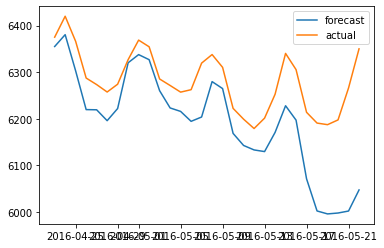

In [14]:
import matplotlib.pyplot as plt

plt.plot(df_results.index, df_results["store_sales_forecast"], label = "forecast")
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()


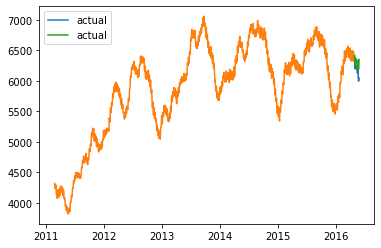

In [15]:
plt.plot(df_results["store_sales_forecast"].index, df_results["store_sales_forecast"], label = "actual")
plt.plot(df_original["store_sales"][0:-nobs].index, df_original["store_sales"][0:-nobs])
plt.plot(df_test.index, df_test["store_sales"], label = "actual")
plt.legend()
plt.show()